In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, plot_confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.manifold import TSNE
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [2]:
def flatten(container):
    "Flattens lists"
    for i in container:
        if isinstance(i, (list, tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

def feature_list(no_of_neighbors):
    """
    Creates a list of features given number of adjacent wells
    param no_of_neighbors: number of adjacent wells used in feature engineering
    """
    print("Getting the features")
    initial = ["thickness", "thickness natural log", "thickness power"]
    features = []
    for item in initial:
        features.append(item)
        for i in range(1, no_of_neighbors + 1):
            features.append(item + " neighbor " + str(i))
    features.append(["x location", "y location", "class"])
    return list(flatten(features))

def data_normalization(dataframe):
    """
    Normalizes the generated stratigraphic data
    param dataframe: a pandas dataframe of thicknesses that has been through feature engineering
    param location: a pandas dataframe with locations 
    """
    print("normalizing")
    normalized_df = (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min()).replace(0, 0.00001)
    return normalized_df
    

def adjacent_wells(dataframe, no_of_neighbors):
    """
    Calculates the adjacent wells and builds the initial dataframe
    param dataframe: dataframe output from the missing function
    param no_of_neighbors: number of adjacent wells used in feature engineering
    """
    hood = squareform(pdist(dataframe.iloc[:, -2:]))
    neighbors = []
    for i in enumerate(hood.argsort()[0:, 1 : no_of_neighbors + 1]):
        selected = (
            dataframe.iloc[hood.argsort()[i[0], 1 : no_of_neighbors + 1], 0:-2]
            .stack()
            .to_frame()
            .T
        )
        selected.columns = selected.columns.droplevel()
        neighbors.append(selected)
    frame = pd.concat(neighbors, sort=False)
    frame.index = range(len(frame))
    neighborhood = pd.concat([dataframe.iloc[:, :-2], frame], axis=1)
    return neighborhood
    
def depth_to_thickness(neighborhood, dataframe):
    """
    Converts the depth dataframe from the adjacent wells function to thicknesses
    param neighborhood: dataframe output from `adjacent_wells`
    param dataframe: dataframe output from function `missing`
    """
    locations = pd.DataFrame()
    df = pd.DataFrame()
    thicknesses = neighborhood.diff(axis=1)*-1
    thicknesses[thicknesses < 0] = 0
    thicknesses.drop(columns=dataframe.columns[0], inplace=True)
    thicknesses[thicknesses < 0] = 0
    thicknesses[thicknesses > 3000] = 0
    locations = pd.concat((locations, dataframe.iloc[:, -2:]))
    df = pd.concat((df, thicknesses))
    return df, locations
  


def build_feature_engineered_dataset(thickness_df, locations_df):
    """
    Takes the generated thickness dataset and runs feature engineering
    param thickness_df: the generated thickness dataset
    param locations_df: the generated locations dataset    
    """
    log_transform = FunctionTransformer(np.log, validate=False)
    power_transform = FunctionTransformer(lambda x: x ** 10, validate=False)
    
    logged = pd.DataFrame(log_transform.transform(thickness_df))
    powered = pd.DataFrame(power_transform.transform(thickness_df)) 
    feature_dataset = (
        pd.concat([thickness_df, logged, powered, locations_df], axis=1)
        .dropna()
        .replace(-np.inf, 0)
    )
    return feature_dataset
  

In [3]:
TRUNCATION_COLOR = "#ffffbf"
ONLAP_COLOR = "#2c7bb6"
HORIZ_COLOR = "#d7191c"
qualcmap = ListedColormap([HORIZ_COLOR,ONLAP_COLOR,TRUNCATION_COLOR])
truncCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", TRUNCATION_COLOR])
onlapCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", ONLAP_COLOR])
horizCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", HORIZ_COLOR])

In [4]:
dataset = pd.read_csv(r'stratigraphic_geometry_dataset.csv', index_col=[0])
wells_in_vicinity = 2
selected_features = feature_list(wells_in_vicinity)
subset = dataset[selected_features]
le = preprocessing.LabelEncoder()
le_class = le.fit_transform(subset['class'])
subset.loc[:,'le_class'] =  le_class
subset.drop('class', inplace=True, axis=1)

Getting the features


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    subset.drop("le_class", axis=1),
    subset["le_class"],
    test_size=0.2,  
    random_state=86,
)

In [6]:
CLF = RandomForestClassifier(n_estimators=1000, bootstrap=False, criterion='entropy', 
                             max_depth=100, min_samples_leaf=10, min_samples_split=10
)
CLF.fit(X_train, y_train)
jaccard_score(y_test, CLF.predict(X_test), average='weighted')

0.8837234122698294

In [7]:
probs = CLF.predict_proba(X_test)
margins = []
for i in enumerate(probs):
    margins.append(sorted(i[1])[-1]-sorted(i[1])[-2])
# mean certainty, 1 is 100% certainty
np.mean(margins) 

0.7284412991078347

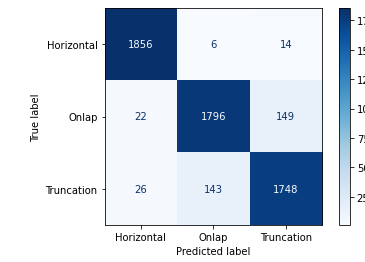

In [8]:
names = ['Horizontal', 'Onlap', 'Truncation']
plot_confusion_matrix(CLF, X_test, y_test, display_labels=names, cmap=plt.cm.Blues)
# plt.savefig('confusion.pdf')

In [9]:
INITIAL = ["thickness", "thickness nl", "thickness po"]
FEATURES = []
for item in INITIAL:
    FEATURES.append(item)
    for i in range(1, wells_in_vicinity + 1):
        FEATURES.append(item + " nearby " + str(i))
FEATURES.append(["x location", "y location", "class"])
FLAT_FEATURES = list(flatten(FEATURES))
subset.columns = FLAT_FEATURES

In [10]:
THICKENED = FLAT_FEATURES[0 : wells_in_vicinity + 1]
THICKENED.append("class")
LOGGED = FLAT_FEATURES[wells_in_vicinity + 1 : 2 * wells_in_vicinity + 2]
LOGGED.append("class")
POWERED = FLAT_FEATURES[2 * wells_in_vicinity + 2 : 3 * wells_in_vicinity + 3]
POWERED.append("class")
LOCATION = ["x location", "y location", "class"]
OG_THICKNESS = ["thickness", "class"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    subset.drop(THICKENED, axis=1),
    subset["class"],
    test_size=0.2, 
    random_state=86,
)
CLF.fit(X_train, y_train)
THICKNESS_REMOVED = jaccard_score(y_test, CLF.predict(X_test), average='weighted')
print(f"Without thickness accuracy is {THICKNESS_REMOVED:.3f}")


X_train, X_test, y_train, y_test = train_test_split(
    subset.drop(LOGGED, axis=1),
    subset["class"],
    test_size=0.2,  
    random_state=86,
)
CLF.fit(X_train, y_train)
LN_REMOVED = jaccard_score(y_test, CLF.predict(X_test), average='weighted')
print(f"Without natural log accuracy is {LN_REMOVED:.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    subset.drop(POWERED, axis=1),
    subset["class"],
    test_size=0.2,  
    random_state=86,
)
CLF.fit(X_train, y_train)
POWER_REMOVED = jaccard_score(y_test, CLF.predict(X_test), average='weighted')
print(f"Without power accuracy is {POWER_REMOVED:.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    subset.drop(LOCATION, axis=1),
    subset["class"],
    test_size=0.2,  
    random_state=86,
)
CLF.fit(X_train, y_train)
LOCATION_REMOVED = jaccard_score(y_test, CLF.predict(X_test), average='weighted')
print(f"Without location accuracy is {LOCATION_REMOVED:.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    subset.drop(OG_THICKNESS, axis=1),
    subset["class"],
    test_size=0.2,  
    random_state=86,
)
CLF.fit(X_train, y_train)
OG_T_REMOVED = jaccard_score(y_test, CLF.predict(X_test), average='weighted')
print(f"Done with well thickness. Accuracy is {OG_T_REMOVED:.2f}")

Without thickness accuracy is 0.854
Without natural log accuracy is 0.63
Without power accuracy is 0.88
Without location accuracy is 0.88
Done with well thickness. Accuracy is 0.88


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    subset.drop("class", axis=1),
    subset["class"],
    test_size=0.001,  
    random_state=86,
)
CLF = RandomForestClassifier(n_estimators=1000, bootstrap=False, criterion='entropy', 
                             max_depth=100, min_samples_leaf=10, min_samples_split=10
)
CLF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=100,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=1000)

Text(0.5, 0, 'Relative Importance')

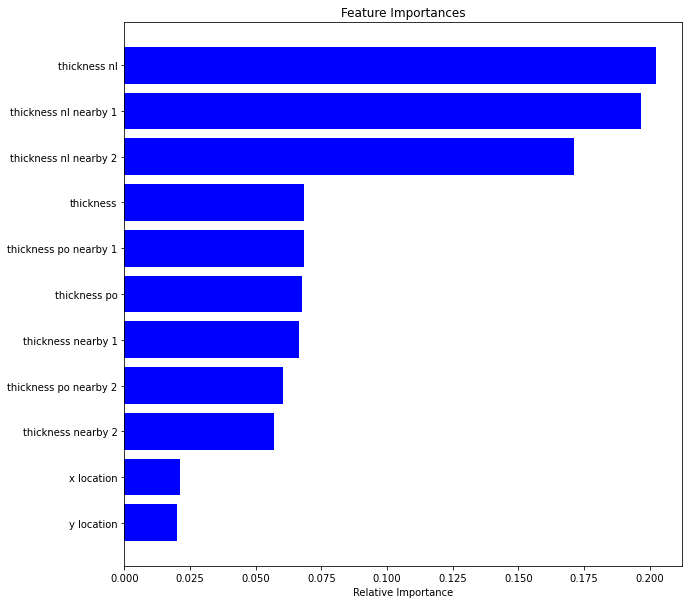

In [13]:
plt.figure(figsize=(10,10))
importances = CLF.feature_importances_
features = subset.columns[:-1].values
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')


In [14]:
# Dataset at https://osf.io/a6cwh/
TOPS_API = pd.read_csv(
    r"subsurface_data.csv"
).fillna(
    0
)  
ITERABLE = ["Kfh", "Kl", "Tfu"]
TOPCOMBOS = list(zip(ITERABLE, ITERABLE[1:]))

RESULTS = []
NORM_ALL = []
PROBS_ALL = []
FULL_PROBS = []
UNC = []
for j in enumerate(TOPCOMBOS):
    print(TOPCOMBOS[j[0]])
    fmtops = list(TOPCOMBOS[j[0]])
    fmtops.extend(["x", "y"])
    tops = TOPS_API[fmtops]
    hoods = adjacent_wells(tops, wells_in_vicinity)
    thicknesses, locations = depth_to_thickness(hoods, tops)
    ft_eng = build_feature_engineered_dataset(thicknesses, locations)
    normalized = data_normalization(ft_eng)
    normalized.columns = FLAT_FEATURES[:-1]
    well_preds = CLF.predict(normalized.values)
    well_prob = CLF.predict_proba(normalized.values)  
    FULL_PROBS.append(well_prob)
    probs = []
    for i in range(len(well_prob)):
        probs.append(well_prob[i].max())
    dists = []
    for i in enumerate(well_prob):
        dists.append(sorted(i[1])[-1]-sorted(i[1])[-2])
    UNC.append(dists)
    PROBS_ALL.append(probs)
    RESULTS.append(well_preds)
    NORM_ALL.append(normalized)

('Kfh', 'Kl')
normalizing
('Kl', 'Tfu')
normalizing


In [15]:
NORMALIZED_KL = NORM_ALL[0]
NORMALIZED_TFU = NORM_ALL[1]

NORMALIZED_KL.columns = subset.columns[0:-1].values
NORMALIZED_KL["class"] = RESULTS[0]
NORMALIZED_KL["prob"] = PROBS_ALL[0]
NORMALIZED_KL["uncer"] = UNC[0]

NORMALIZED_TFU.columns = subset.columns[0:-1].values
NORMALIZED_TFU["class"] = RESULTS[1]
NORMALIZED_TFU["prob"] = PROBS_ALL[1]
NORMALIZED_TFU["uncer"] = PROBS_ALL[1]

NORMALIZED_KL["Formation"] = "Kl"  # this is lance
NORMALIZED_TFU["Formation"] = "Tfu"  # this is ft union

DF_COMBINED = NORMALIZED_KL
DF_COMBINED1 = DF_COMBINED.append(NORMALIZED_TFU, sort=False)

## Now let's project the predictions down to 2D with T-SNE

In [16]:
DF_SUBSET1 = DF_COMBINED1.drop(["class", "Formation", "prob"], axis=1)
tsne = TSNE(
    n_components=2,
    verbose=0.2,
    perplexity=50,
    n_iter=1500,
    learning_rate=500,
    random_state=20,
)  
TSNE_RESULTS = tsne.fit_transform(DF_SUBSET1)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1776 samples in 0.007s...
[t-SNE] Computed neighbors for 1776 samples in 0.103s...
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.402145
[t-SNE] KL divergence after 1500 iterations: 0.324735


In [17]:
PROBABILITIES = np.vstack(FULL_PROBS)

DF_COMBINED1["horiz_prob"] = PROBABILITIES[:, 0]
DF_COMBINED1["onlap_prob"] = PROBABILITIES[:, 1]
DF_COMBINED1["trunc_prob"] = PROBABILITIES[:, 2]

Text(0, 0.5, 't-SNE Dimension 2')

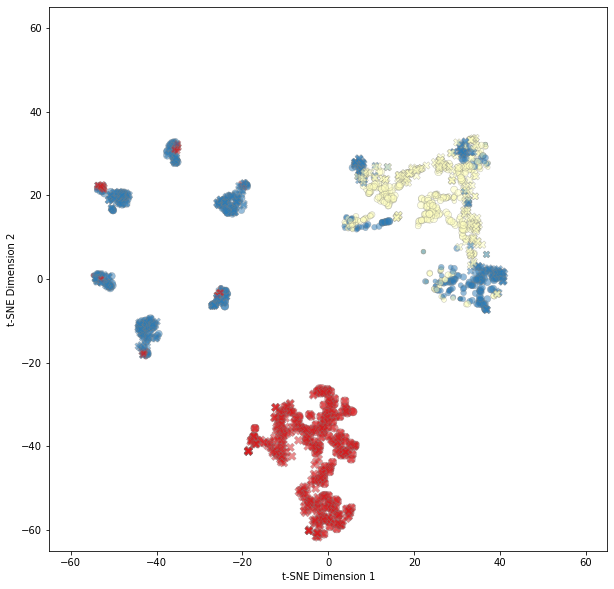

In [18]:
DF_COMBINED1["tsne-2d-one"] = TSNE_RESULTS[:, 0]
DF_COMBINED1["tsne-2d-two"] = TSNE_RESULTS[:, 1]
color_pals = ["#ffffbf", "#2c7bb6", "#d7191c"]

# 0 is truncation, 1 is onlap, 2 is horizontal

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=DF_COMBINED1["tsne-2d-one"],
    y=DF_COMBINED1["tsne-2d-two"],
    hue=DF_COMBINED1["class"],
    style=DF_COMBINED1["Formation"],
    palette=qualcmap,
    data=DF_COMBINED1,
    legend=None,
    alpha=0.5,
    edgecolor="gray",
    vmin=-1,
    vmax=1,
    size=DF_COMBINED1['uncer']
)
plt.xlim(-65, 65)
plt.ylim(-65, 65)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
# plt.savefig('tsne_trunc.pdf')

In [19]:
x_locs = TOPS_API.x.append(TOPS_API.x, ignore_index=True)
y_locs = TOPS_API.y.append(TOPS_API.y, ignore_index=True)
API = TOPS_API.API.append(TOPS_API.API, ignore_index=True)

DF_COMBINED1["x_locs"] = x_locs
DF_COMBINED1["y_locs"] = y_locs
DF_COMBINED1["api"] = API

In [20]:
FTUNION = DF_COMBINED1[DF_COMBINED1["Formation"] == "Tfu"]
LANCER = DF_COMBINED1[DF_COMBINED1["Formation"] == "Kl"]

In [21]:
FTUNION = FTUNION[['class', 'thickness', 'Formation', 'uncer', 'horiz_prob', 'onlap_prob', 'trunc_prob', 'tsne-2d-one', 'tsne-2d-two', 'x_locs', 'y_locs', 'api']]

LANCER = LANCER[['class', 'thickness', 'Formation', 'uncer', 'horiz_prob', 'onlap_prob', 'trunc_prob', 'tsne-2d-one', 'tsne-2d-two', 'x_locs', 'y_locs', 'api']]

In [22]:
geometry = [Point(xy) for xy in zip(FTUNION.x_locs, FTUNION.y_locs)]
crs = {"init": "epsg:3732"}
geo_df = GeoDataFrame(FTUNION, crs={"init": "epsg:4326"}, geometry=geometry)
geo_df.to_file(
    driver="ESRI Shapefile",
    filename=r"predictions/ftunion_predictions_prob.shp",
 )

In [23]:
geometry = [Point(xy) for xy in zip(LANCER.x_locs, LANCER.y_locs)]
crs = {"init": "epsg:3732"}
geo_df = GeoDataFrame(LANCER, crs={"init": "epsg:4326"}, geometry=geometry)
geo_df.to_file(
    driver="ESRI Shapefile",
    filename=r"predictions/lance_predictions_prob.shp",
 )